In [1]:
import pandas as pd
import sqlite3

In [2]:
connect_db = sqlite3.connect('../data/checking-logs.sqlite.sqlite')
query = 'PRAGMA table_info(checker);'
pd.io.sql.read_sql(query, connect_db)

,cid,name,type,notnull,dflt_value,pk
0,0,index,INTEGER,0,None,0
1,1,status,TEXT,0,None,0
2,2,success,INTEGER,0,None,0
3,3,timestamp,TIMESTAMP,0,None,0
4,4,numTrials,INTEGER,0,None,0
5,5,labname,TEXT,0,None,0
6,6,uid,TEXT,0,None,0


In [3]:
query = '''
        select uid, timestamp from checker where uid like 'user_%'
        '''
df = pd.io.sql.read_sql(query, connect_db, parse_dates=['timestamp'])
df.head()

,uid,timestamp
0,user_4,2020-04-17 05:19:02.744528
1,user_4,2020-04-17 05:22:35.249331
2,user_4,2020-04-17 05:22:45.549397
3,user_4,2020-04-17 05:34:14.691200
4,user_4,2020-04-17 05:34:24.422370


In [4]:
df['date'] = df.timestamp.dt.date
df['hour'] = df.timestamp.dt.hour
interval = ['night', 'morning', 'afternoon', 'evening']
df['daytime'] = pd.cut(df['hour'], [0, 4, 10, 17, 24], labels=interval, include_lowest=True, right=False)

In [5]:
for_plot = df.groupby(by=['date', 'daytime']).count()['hour'].reset_index()
for_plot.hour.fillna(0, inplace=True)
for_plot

,date,daytime,hour
0,2020-04-17,night,0
1,2020-04-17,morning,13
2,2020-04-17,afternoon,10
3,2020-04-17,evening,0
4,2020-04-18,night,0
...,...,...,...
135,2020-05-20,evening,10
136,2020-05-21,night,0
137,2020-05-21,morning,1
138,2020-05-21,afternoon,27


In [7]:
for_plot_pivot = pd.pivot(for_plot, values='hour', index='date', columns='daytime')
for_plot_pivot.head()

daytime,night,morning,afternoon,evening
date,,,,
2020-04-17,0,13,10,0
2020-04-18,0,1,33,35
2020-04-19,2,4,16,11
2020-04-20,0,0,12,13
2020-04-21,0,0,0,25


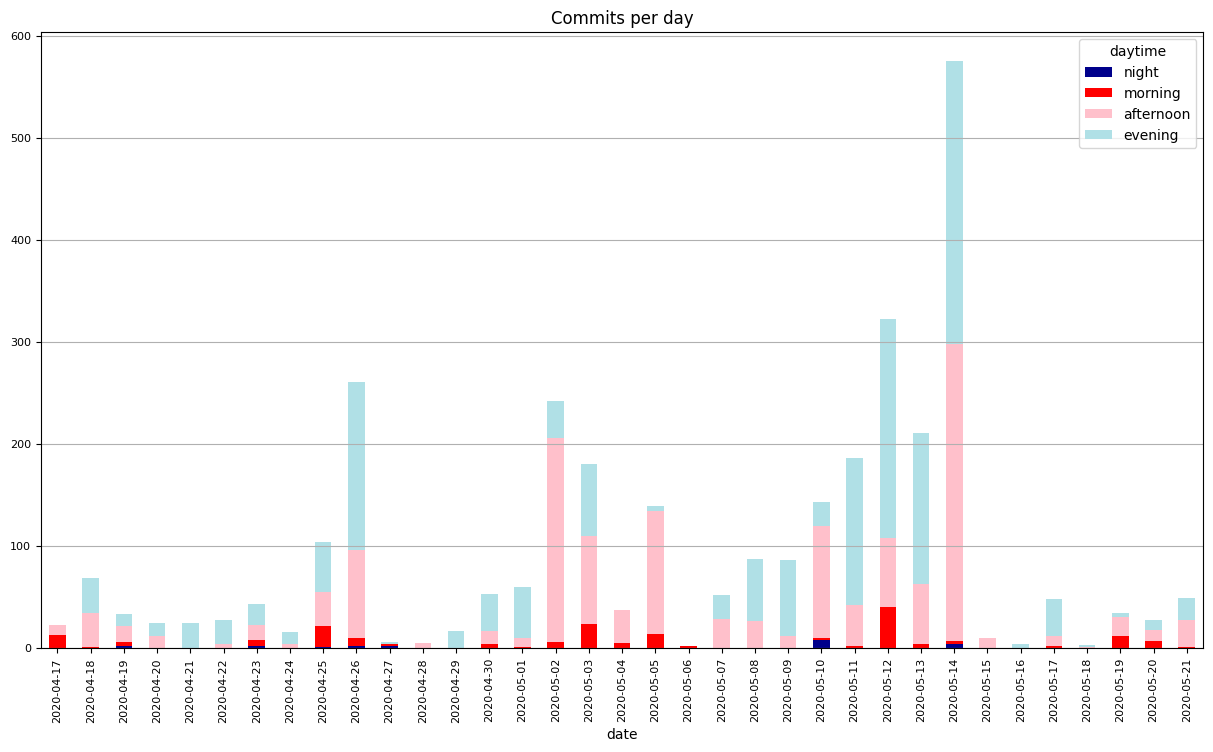

In [8]:
plot = for_plot_pivot.plot(kind='bar', figsize= (15,8), title = 'Commits per day', fontsize=8, xlabel = 'date', rot = 90, color = ['#00008B', 'red', '#FFC0CB', '#B0E0E6'], stacked=True)
plot.grid('on', which='major', axis='y')

In [9]:
s = {'evening':for_plot_pivot.evening.sum(), 'morning':for_plot_pivot.morning.sum(), 'afternoon':for_plot_pivot.afternoon.sum(), 'night':for_plot_pivot.night.sum()}
dict(sorted(s.items(), key=lambda item: item[1]))

{'night': 21, 'morning': 184, 'afternoon': 1391, 'evening': 1611}

In [11]:
for_plot_pivot[for_plot_pivot.evening > for_plot_pivot.afternoon].sum(axis=1).sort_values()

date
2020-05-18      3
2020-05-16      4
2020-04-27      6
2020-04-24     16
2020-04-29     17
2020-04-21     25
2020-04-20     25
2020-04-22     28
2020-04-23     43
2020-05-17     48
2020-04-30     53
2020-05-01     60
2020-04-18     69
2020-05-09     86
2020-05-08     87
2020-04-25    104
2020-05-11    186
2020-05-13    211
2020-04-26    261
2020-05-12    323
dtype: int64

In [12]:
connect_db.close()